MVO Model

Algorithm for MVO:
Markowitz Mean-Variance Optimization (Baseline Model):
This traditional model is used both as a benchmark and as a component within the inverse optimization. Its pseudocode is:

Algorithm MeanVarianceOptimization:
    Input: Expected returns vector μ, covariance matrix Σ, risk aversion parameter ρ
    Solve:
        Maximize: μ^T x - ρ * (x^T Σ x)
        Subject to: sum(x) = 1 and x_i >= 0 for all i  (no short selling)
    Output: Optimal portfolio weights x*

In [10]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import os

# ---------------------
# Configuration
# ---------------------
data_folder = "/Users/alisadiq/Library/CloudStorage/OneDrive-UniversityofGreenwich/Documents/Year 3/FYP/Data/Processed"
damodaran_data_path = "/Users/alisadiq/Library/CloudStorage/OneDrive-UniversityofGreenwich/Documents/Year 3/FYP/Data/Damodaran- Expected Returns/histretSP.xlsx"
annualization_factor = 252  # For daily returns (choose 252 trading days) if annualization is desired

# ---------------------
# Data Loading
# ---------------------
def load_csv(filepath):
    try:
        return pd.read_csv(filepath)
    except Exception as e:
        raise Exception(f"Failed to load file {filepath}: {e}")

sp500_file = os.path.join(data_folder, "processed_sp500_data.csv")
bond_file = os.path.join(data_folder, "processed_bond_data.csv")
risk_free_file = os.path.join(data_folder, "processed_risk_free_rate_data.csv")

sp500_data = load_csv(sp500_file)
bond_data = load_csv(bond_file)
risk_free_rate_data = load_csv(risk_free_file)
damodaran_data = pd.read_excel(damodaran_data_path)  # Not used in current model, but loaded for extension

# ---------------------
# Data Preprocessing
# ---------------------
# Convert 'Date' columns to datetime
for df in [sp500_data, bond_data, risk_free_rate_data]:
    if "Date" in df.columns:
        df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

# Merge datasets on 'Date'
try:
    financial_data = pd.merge(sp500_data[["Date", "SP500_Close"]], 
                              bond_data[["Date", "BAMLC0A0CMEY"]],
                              on="Date", how="inner")
    financial_data = pd.merge(financial_data, 
                              risk_free_rate_data[["Date", "DGS1MO"]],
                              on="Date", how="inner")
except Exception as e:
    raise Exception("Error while merging datasets: " + str(e))

# Rename columns for clarity
financial_data.rename(columns={
    "SP500_Close": "SP500", 
    "BAMLC0A0CMEY": "USBIG", 
    "DGS1MO": "RiskFreeRate"
}, inplace=True)

# Handle missing values
financial_data = financial_data.ffill().bfill()

# Calculate daily returns
financial_data["SP500_Return"] = financial_data["SP500"].pct_change()
financial_data["USBIG_Return"] = financial_data["USBIG"].pct_change()

# Drop remaining NaN values
financial_data.dropna(inplace=True)

# ---------------------
# Split Data into Training and Testing Sets
# ---------------------
train_data = financial_data[financial_data["Date"] < "2020-01-01"]
test_data = financial_data[financial_data["Date"] >= "2020-01-01"]

# ---------------------
# Statistics Calculation
# ---------------------
def calculate_statistics(data):
    returns = data[["SP500_Return", "USBIG_Return"]]
    expected_returns = returns.mean().values
    covariance_matrix = returns.cov().values
    return expected_returns, covariance_matrix

# ---------------------
# Portfolio Optimization Function
# ---------------------
def optimize_portfolio(expected_returns, covariance_matrix, risk_aversion):
    num_assets = len(expected_returns)
    
    def objective_function(weights, returns, cov_matrix, risk_aversion):
        # Calculate portfolio return and risk (variance)
        port_return = np.dot(weights, returns)
        port_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
        # We minimize the negative utility: -(return - risk_aversion * variance)
        return -(port_return - risk_aversion * port_variance)
    
    # Constraints: weights sum to 1
    constraints = {"type": "eq", "fun": lambda weights: np.sum(weights) - 1}
    
    # Bounds: weights between 0 and 1 (no short selling)
    bounds = [(0, 1) for _ in range(num_assets)]
    
    # Initial guess: equal weights
    initial_weights = np.ones(num_assets) / num_assets
    
    result = minimize(
        objective_function,
        x0=initial_weights,
        args=(expected_returns, covariance_matrix, risk_aversion),
        method="SLSQP",
        bounds=bounds,
        constraints=constraints
    )
    
    if result.success:
        return result.x
    else:
        raise ValueError("Optimization failed: " + result.message)

# ---------------------
# Portfolio Performance Evaluation
# ---------------------
def evaluate_portfolio(weights, expected_returns, covariance_matrix, risk_free_rate, annualize=False):
    portfolio_return = np.dot(weights, expected_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))
    
    if annualize:
        portfolio_return *= annualization_factor
        portfolio_volatility *= np.sqrt(annualization_factor)
    
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    return {
        "Portfolio Return": portfolio_return,
        "Portfolio Volatility": portfolio_volatility,
        "Sharpe Ratio": sharpe_ratio
    }

# ---------------------
# Main Execution for Training and Testing
# ---------------------
if __name__ == "__main__":
    # Example: using a fixed risk aversion parameter.
    risk_aversion = 3
    
    # Training set optimization and evaluation
    try:
        train_expected_returns, train_covariance_matrix = calculate_statistics(train_data)
        optimal_weights_train = optimize_portfolio(train_expected_returns, train_covariance_matrix, risk_aversion)
        print("Optimal Weights (Training Set):", optimal_weights_train)
        
        # Note: risk_free_rate provided as a percentage; hence division by 100.
        avg_rf_train = train_data["RiskFreeRate"].mean() / 100  
        train_performance = evaluate_portfolio(optimal_weights_train, train_expected_returns, train_covariance_matrix, avg_rf_train, annualize=True)
        print("Performance (Training Set):", train_performance)
    except Exception as e:
        print("Optimization failed (Training Set):", e)
    
    # Testing set optimization and evaluation
    try:
        test_expected_returns, test_covariance_matrix = calculate_statistics(test_data)
        optimal_weights_test = optimize_portfolio(test_expected_returns, test_covariance_matrix, risk_aversion)
        print("Optimal Weights (Testing Set):", optimal_weights_test)
        
        avg_rf_test = test_data["RiskFreeRate"].mean() / 100  
        test_performance = evaluate_portfolio(optimal_weights_test, test_expected_returns, test_covariance_matrix, avg_rf_test, annualize=True)
        print("Performance (Testing Set):", test_performance)
    except Exception as e:
        print("Optimization failed (Testing Set):", e)


Optimal Weights (Training Set): [0.5 0.5]
Performance (Training Set): {'Portfolio Return': np.float64(0.0174136005794612), 'Portfolio Volatility': np.float64(0.11734360144079337), 'Sharpe Ratio': np.float64(0.10020323319341509)}
Optimal Weights (Testing Set): [0.5 0.5]
Performance (Testing Set): {'Portfolio Return': np.float64(0.16490771962501916), 'Portfolio Volatility': np.float64(0.14987492019665305), 'Sharpe Ratio': np.float64(1.0544880985934861)}


Now, we'll run the model for Inverse Optimisation,
The Algorithm:
Inverse Optimization for Risk Aversion Estimation:
The idea is to use observed portfolio holdings (from mutual funds) to infer the risk aversion parameter that would yield the optimal portfolio under the Markowitz mean-variance framework. In pseudocode, this process could be represented as:

Algorithm InverseOptimizationRiskAversion:
    Input: Observed portfolio holdings H, risk aversion candidate set Ψ
    For each candidate ρ in Ψ:
        Compute optimal portfolio weights x*(ρ) using Mean-Variance Optimization:
            Maximize: Expected_Return(x) - ρ * Variance(x)
            Subject to: sum(x) = 1 and x_i >= 0 for all i
        Calculate prediction error E(ρ) = || x*(ρ) - H ||
    End For
    Select ρ* = argmin E(ρ)  // Candidate with minimum error
    Output: Estimated risk aversion ρ*

Inverse Optimisation


In [11]:
import os
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# Assume these functions are defined in your MVO code cell (or imported):
def calculate_statistics(data):
    returns = data[["SP500_Return", "USBIG_Return"]]
    expected_returns = returns.mean().values
    covariance_matrix = returns.cov().values
    return expected_returns, covariance_matrix

def optimize_portfolio(expected_returns, covariance_matrix, risk_aversion):
    num_assets = len(expected_returns)
    
    def objective_function(weights, returns, cov_matrix, risk_aversion):
        port_return = np.dot(weights, returns)
        port_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
        # Negative utility: -(return - risk_aversion*variance)
        return -(port_return - risk_aversion * port_variance)
    
    constraints = {"type": "eq", "fun": lambda w: np.sum(w) - 1}
    bounds = [(0, 1)] * num_assets
    initial_weights = np.ones(num_assets) / num_assets
    
    result = minimize(
        objective_function,
        x0=initial_weights,
        args=(expected_returns, covariance_matrix, risk_aversion),
        method="SLSQP",
        bounds=bounds,
        constraints=constraints
    )
    
    if result.success:
        return result.x
    else:
        raise ValueError("Optimization failed: " + result.message)

# ---------------------
# Inverse Optimization: Estimate Risk Aversion
# ---------------------
def estimate_risk_aversion(observed_weights, expected_returns, covariance_matrix, candidate_range):
    errors = []
    candidate_risk = []
    best_error = np.inf
    best_risk = None
    best_weights = None

    for risk_aversion in candidate_range:
        try:
            model_weights = optimize_portfolio(expected_returns, covariance_matrix, risk_aversion)
            error = np.linalg.norm(model_weights - observed_weights)
            errors.append(error)
            candidate_risk.append(risk_aversion)
            if error < best_error:
                best_error = error
                best_risk = risk_aversion
                best_weights = model_weights
        except Exception as e:
            print(f"Risk aversion candidate {risk_aversion} failed: {e}")
            continue

    return best_risk, best_weights, candidate_risk, errors

# ---------------------
# Load Synthetic Mutual Fund Data 
# ---------------------
def load_synthetic_mutual_fund_data(file_path="/Users/alisadiq/Library/CloudStorage/OneDrive-UniversityofGreenwich/Documents/Year 3/FYP/Data/Processed/MutualFunds/mutual_fund_allocations.csv"):
    """
    Load the synthetic mutual fund allocation data
    """
    try:
        # Load the synthetic mutual fund allocations
        synth_data = pd.read_csv(file_path)
        
        # Verify the data has the expected columns
        required_cols = [col for col in synth_data.columns if '_stock' in col or '_bond' in col]
        if not required_cols:
            raise ValueError(f"Synthetic data file does not contain expected columns (_stock, _bond)")
            
        print(f"Successfully loaded synthetic mutual fund data with {len(synth_data)} time periods")
        return synth_data
    except Exception as e:
        print(f"Error loading synthetic mutual fund data: {e}")
        return None

# ---------------------
# Process Synthetic Data to Extract Observed Weights
# ---------------------
def extract_observed_weights(synth_data, date=None):
    """
    Extract average weights across funds for a specific date or for the entire period
    """
    # If date is provided, filter to that date
    if date is not None:
        if 'Date' in synth_data.columns:
            synth_data = synth_data[synth_data['Date'] == date]
            if len(synth_data) == 0:
                print(f"No data found for date {date}, using all data")
                synth_data = synth_data  # Reset to full dataset
    
    # Get lists of stock and bond columns
    stock_cols = [col for col in synth_data.columns if '_stock' in col]
    bond_cols = [col for col in synth_data.columns if '_bond' in col]
    
    # Calculate average weights across all funds and time periods
    avg_stock_weight = synth_data[stock_cols].mean().mean()
    avg_bond_weight = synth_data[bond_cols].mean().mean()
    
    # Ensure weights sum to 1
    total = avg_stock_weight + avg_bond_weight
    avg_stock_weight /= total
    avg_bond_weight /= total
    
    print(f"Observed Average Weights (stocks, bonds): [{avg_stock_weight:.4f}, {avg_bond_weight:.4f}]")
    
    # Return as numpy array for the optimization function
    return np.array([avg_stock_weight, avg_bond_weight])

# ---------------------
# Main Execution
# ---------------------
# Load the synthetic mutual fund data
synth_data = load_synthetic_mutual_fund_data()

# Extract observed weights from synthetic data
observed_weights = extract_observed_weights(synth_data)
print("Observed Average Mutual Fund Weights (stocks, bonds):", observed_weights)

# For the MVO part, we use the financial data as in your MVO file
# (Assuming financial_data was built in a previous cell and split into train_data.)
# For demonstration, we assume train_data exists.

# If not already defined, here's a dummy example:
# (In practice, you will use your preprocessed train_data from the MVO code.)
# train_data = financial_data[financial_data["Date"] < "2020-01-01"]

train_expected_returns, train_covariance_matrix = calculate_statistics(train_data)

# ---------------------
# Estimate Risk Aversion via Inverse Optimization
# ---------------------
# Define a candidate risk aversion range (for example, from 0.1 to 10)
candidate_range = np.linspace(0.1, 10, 100)

best_risk, best_model_weights, candidate_risk, errors = estimate_risk_aversion(
    observed_weights, train_expected_returns, train_covariance_matrix, candidate_range
)

print("Estimated Risk Aversion Parameter:", best_risk)
print("Optimal Weights (MVO) at Estimated Risk Aversion:", best_model_weights)

# Optional: Save the candidate risk vs. error data for further analysis
results_df = pd.DataFrame({
    "Risk_Aversion": candidate_risk,
    "Error": errors
})
results_df.to_csv("inverse_optimization_results.csv", index=False)
print("Inverse optimization results saved to 'inverse_optimization_results.csv'.")

Successfully loaded synthetic mutual fund data with 180 time periods
Observed Average Weights (stocks, bonds): [0.6823, 0.3177]
Observed Average Mutual Fund Weights (stocks, bonds): [0.68231419 0.31768581]
Estimated Risk Aversion Parameter: 0.1
Optimal Weights (MVO) at Estimated Risk Aversion: [0.5 0.5]
Inverse optimization results saved to 'inverse_optimization_results.csv'.


Deep RL (Portfolio Weights)

Using risk aversion parameter from inverse optimization: 0.1
Using cpu device
Logging to /Users/alisadiq/Library/CloudStorage/OneDrive-UniversityofGreenwich/Documents/Year 3/FYP/Models/DeepRL/tensorboard_logs/PPO_39


/Users/alisadiq/.pyenv/versions/3.10.12/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/Users/alisadiq/.pyenv/versions/3.10.12/lib/python3.10/site-packages/stable_baselines3/common/policies.py:486: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(


-----------------------------
| time/              |      |
|    fps             | 2628 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 1024 |
-----------------------------


/Users/alisadiq/.pyenv/versions/3.10.12/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=2000, episode_reward=-70.24 +/- 0.00
Episode length: 2936.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 2.94e+03    |
|    mean_reward          | -70.2       |
| time/                   |             |
|    total_timesteps      | 2000        |
| train/                  |             |
|    approx_kl            | 0.002444791 |
|    clip_fraction        | 0.00645     |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.582       |
|    explained_variance   | -1.18       |
|    learning_rate        | 5e-05       |
|    loss                 | 0.0551      |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00307    |
|    std                  | 0.135       |
|    value_loss           | 0.13        |
-----------------------------------------
New best mean reward!
-----------------------------
| time/              |      |
|    fps             | 522  |
|

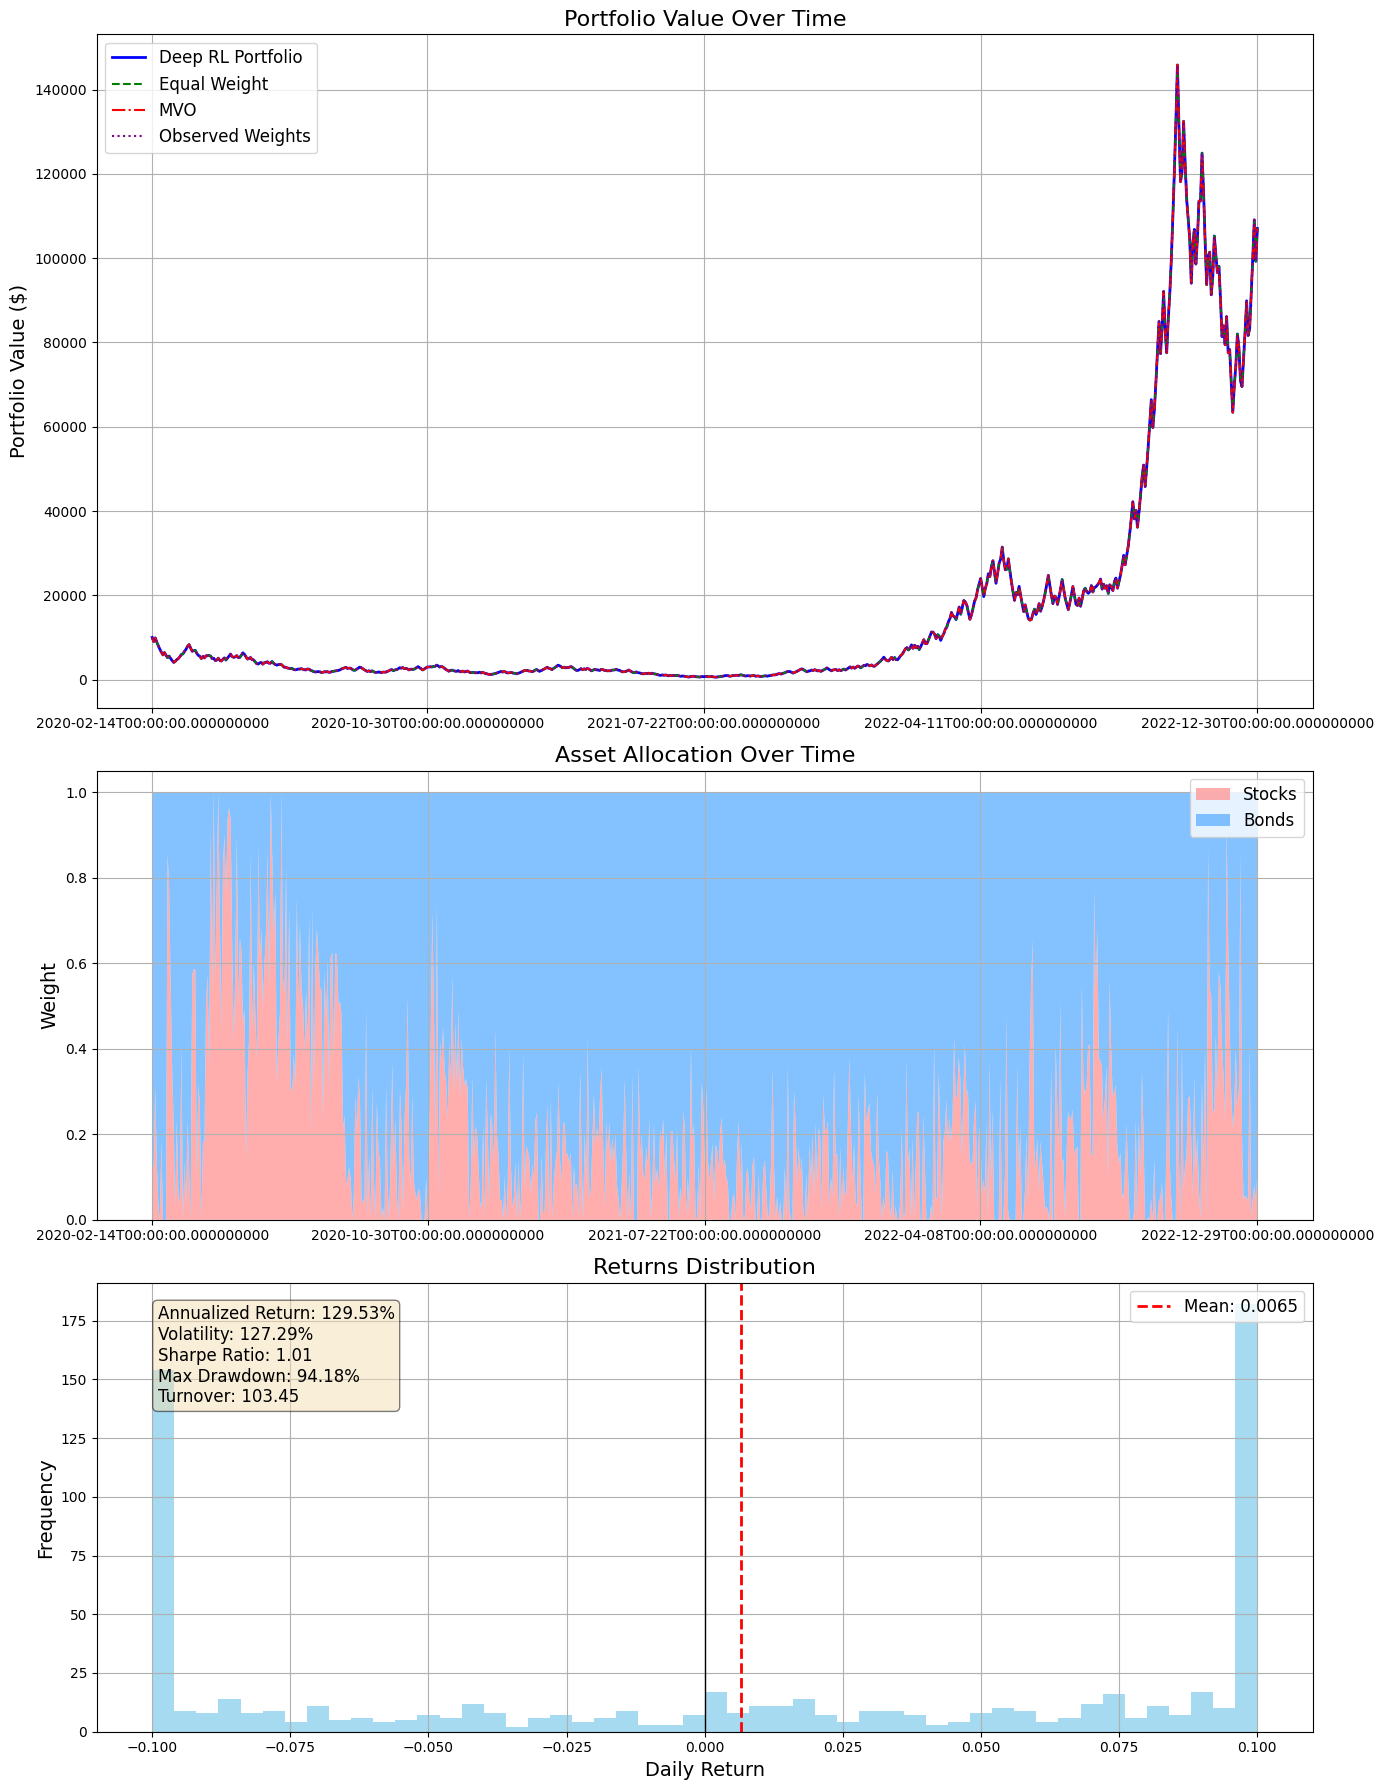

Metrics saved to /Users/alisadiq/Library/CloudStorage/OneDrive-UniversityofGreenwich/Documents/Year 3/FYP/Results/portfolio_metrics.csv
Allocation weights saved to /Users/alisadiq/Library/CloudStorage/OneDrive-UniversityofGreenwich/Documents/Year 3/FYP/Results/portfolio_allocations.csv


In [12]:
import os
import torch
import numpy as np
import pandas as pd
import gym
from gym import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import StopTrainingOnNoModelImprovement, EvalCallback
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# ---------------------
# Configuration
# ---------------------
data_folder = "/Users/alisadiq/Library/CloudStorage/OneDrive-UniversityofGreenwich/Documents/Year 3/FYP/Data/Processed"
results_folder = "/Users/alisadiq/Library/CloudStorage/OneDrive-UniversityofGreenwich/Documents/Year 3/FYP/Results"
model_folder = "/Users/alisadiq/Library/CloudStorage/OneDrive-UniversityofGreenwich/Documents/Year 3/FYP/Models/DeepRL"

# Ensure directories exist
os.makedirs(results_folder, exist_ok=True)
os.makedirs(model_folder, exist_ok=True)

# ---------------------
# Data Loading and Preprocessing
# ---------------------
def load_and_preprocess_data(split_date="2020-01-01"):
    """
    Load financial data, preprocess it, and split into training and testing sets.
    
    Args:
        split_date (str): Date to split training and testing data
        
    Returns:
        tuple: (train_data, test_data, risk_aversion, scaler)
    """
    # Load datasets
    sp500_data = pd.read_csv(os.path.join(data_folder, "processed_sp500_data.csv"))
    bond_data = pd.read_csv(os.path.join(data_folder, "processed_bond_data.csv"))
    risk_free_rate_data = pd.read_csv(os.path.join(data_folder, "processed_risk_free_rate_data.csv"))
    
    # Load risk aversion from inverse optimization results
    inverse_opt_results = pd.read_csv("/Users/alisadiq/Library/CloudStorage/OneDrive-UniversityofGreenwich/Documents/Year 3/FYP/Models/inverse_optimization_results.csv")
    
    # Convert date columns to datetime
    sp500_data["Date"] = pd.to_datetime(sp500_data["Date"])
    bond_data["Date"] = pd.to_datetime(bond_data["Date"])
    risk_free_rate_data["Date"] = pd.to_datetime(risk_free_rate_data["Date"])
    
    # Merge datasets
    financial_data = pd.merge(sp500_data[["Date", "SP500_Close"]], 
                            bond_data[["Date", "BAMLC0A0CMEY"]],
                            on="Date", how="inner")
    financial_data = pd.merge(financial_data, 
                            risk_free_rate_data[["Date", "DGS1MO"]],
                            on="Date", how="inner")
    
    # Rename columns for clarity
    financial_data.rename(columns={
        "SP500_Close": "SP500", 
        "BAMLC0A0CMEY": "Bond", 
        "DGS1MO": "RiskFreeRate"
    }, inplace=True)
    
    # Handle missing values
    financial_data = financial_data.ffill().bfill()
    
    # Calculate daily returns
    financial_data["SP500_Return"] = financial_data["SP500"].pct_change()
    financial_data["Bond_Return"] = financial_data["Bond"].pct_change()
    
    # Handle extreme returns by clipping
    financial_data["SP500_Return"] = financial_data["SP500_Return"].clip(-0.1, 0.1)
    financial_data["Bond_Return"] = financial_data["Bond_Return"].clip(-0.1, 0.1)
    
    # Calculate technical indicators
    # 1. Moving averages
    financial_data["SP500_MA30"] = financial_data["SP500"].rolling(window=30).mean()
    financial_data["Bond_MA30"] = financial_data["Bond"].rolling(window=30).mean()
    
    # 2. Volatility (standard deviation over rolling window)
    financial_data["SP500_Volatility"] = financial_data["SP500_Return"].rolling(window=20).std()
    financial_data["Bond_Volatility"] = financial_data["Bond_Return"].rolling(window=20).std()
    
    # 3. Price relative to moving average (normalized)
    financial_data["SP500_RelToMA"] = (financial_data["SP500"] / financial_data["SP500_MA30"]) - 1
    financial_data["Bond_RelToMA"] = (financial_data["Bond"] / financial_data["Bond_MA30"]) - 1
    
    # Drop rows with NaN values
    financial_data.dropna(inplace=True)
    
    # Replace infinite values with something reasonable
    for col in financial_data.columns:
        if financial_data[col].dtype != 'object' and financial_data[col].dtype != 'datetime64[ns]':
            # Replace infinities with large but finite values
            financial_data[col] = financial_data[col].replace([np.inf, -np.inf], [1.0, -1.0])
    
    # Normalize features for RL
    from sklearn.preprocessing import RobustScaler  # Using RobustScaler instead of MinMaxScaler for better outlier handling
    feature_columns = [
        "SP500_Return", "Bond_Return", "SP500_Volatility", "Bond_Volatility",
        "SP500_RelToMA", "Bond_RelToMA", "RiskFreeRate"
    ]
    
    # Check for any remaining NaN or infinite values before scaling
    for col in feature_columns:
        if financial_data[col].isna().any() or np.isinf(financial_data[col]).any():
            print(f"Warning: Column {col} contains NaN or Inf values. Replacing with zeros.")
            financial_data[col] = financial_data[col].replace([np.inf, -np.inf], [1.0, -1.0])
            financial_data[col] = financial_data[col].fillna(0)
    
    scaler = RobustScaler()
    financial_data[feature_columns] = scaler.fit_transform(financial_data[feature_columns])
    
    # Additional safety check - cap normalized values to prevent extreme outliers
    for col in feature_columns:
        financial_data[col] = financial_data[col].clip(-3, 3)
    
    # Split data into train and test sets
    train_data = financial_data[financial_data["Date"] < split_date].copy()
    test_data = financial_data[financial_data["Date"] >= split_date].copy()
    
    # Get risk aversion from inverse optimization results
    if not inverse_opt_results.empty and "Risk_Aversion" in inverse_opt_results.columns:
        best_idx = inverse_opt_results["Error"].idxmin() if not inverse_opt_results["Error"].isna().all() else 0
        risk_aversion = inverse_opt_results.iloc[best_idx]["Risk_Aversion"]
    else:
        # Default risk aversion if no inverse optimization results available
        risk_aversion = 1.0  # Using a moderate default value
    
    return train_data, test_data, risk_aversion, scaler

# Calculate maximum drawdown
def calculate_max_drawdown(portfolio_values):
    """Calculate the maximum drawdown of a portfolio"""
    portfolio_values = np.array(portfolio_values)
    if len(portfolio_values) <= 1:
        return 0.0
    
    cumulative_max = np.maximum.accumulate(portfolio_values)
    drawdown = (portfolio_values - cumulative_max) / np.maximum(cumulative_max, 1e-10)  # Avoid division by zero
    max_drawdown = np.min(drawdown) if len(drawdown) > 0 else 0
    return abs(max_drawdown)

# ---------------------
# Custom RL Environment with Improved Numerical Stability
# ---------------------
class PortfolioAllocationEnv(gym.Env):
    """Custom Environment for Portfolio Allocation using Deep RL"""
    
    def __init__(self, data, risk_aversion=3.0, window_size=30):
        super(PortfolioAllocationEnv, self).__init__()
        
        # Make a copy of the data to avoid modifying the original
        self.data = data.reset_index(drop=True).copy()
        self.risk_aversion = risk_aversion
        self.window_size = window_size
        
        # Ensure data has enough rows
        if len(self.data) <= window_size + 10:  # Need some buffer for evaluation
            raise ValueError(f"Data has {len(self.data)} rows, need more than {window_size + 10}")
        
        self.current_step = window_size
        self.max_steps = len(self.data) - 1
        
        # Define action space: continuous allocation between assets
        self.action_space = spaces.Box(
            low=0, high=1, shape=(1,), dtype=np.float32
        )
        
        # Define observation space with market features
        n_features = 7  # Using 7 features for state representation
        self.observation_space = spaces.Box(
            low=-5, high=5, shape=(n_features,), dtype=np.float32
        )
        
        # Track portfolio performance
        self.portfolio_value = 10000  # Initial portfolio value
        self.portfolio_history = []
        self.weights_history = []
        self.returns_history = []
        
    def reset(self):
        """Reset the environment to start a new episode"""
        self.current_step = self.window_size
        self.portfolio_value = 10000
        self.portfolio_history = [self.portfolio_value]
        self.weights_history = []
        self.returns_history = []
        return self._get_observation()
    
    def _get_observation(self):
        """Get the current state observation with robust error handling"""
        try:
            obs = np.array([
                float(self.data.loc[self.current_step, "SP500_Return"]),
                float(self.data.loc[self.current_step, "Bond_Return"]),
                float(self.data.loc[self.current_step, "SP500_Volatility"]),
                float(self.data.loc[self.current_step, "Bond_Volatility"]),
                float(self.data.loc[self.current_step, "SP500_RelToMA"]),
                float(self.data.loc[self.current_step, "Bond_RelToMA"]),
                float(self.data.loc[self.current_step, "RiskFreeRate"]) / 100.0  # Convert to decimal
            ], dtype=np.float32)
            
            # Check for NaN or Inf values
            if np.isnan(obs).any() or np.isinf(obs).any():
                print(f"Warning: NaN or Inf in observation at step {self.current_step}, replacing with zeros")
                obs = np.nan_to_num(obs, nan=0.0, posinf=0.0, neginf=0.0)
            
            # Clip values to ensure they are within reasonable bounds
            obs = np.clip(obs, -5.0, 5.0)
            
            return obs
        except Exception as e:
            print(f"Error getting observation at step {self.current_step}: {e}")
            # Return a safe default observation
            return np.zeros(7, dtype=np.float32)
    
    def step(self, action):
        """Take action and observe next state and reward"""
        # Extract the weight for stocks from action
        stock_weight = float(np.clip(action[0], 0.0, 1.0))  # Ensure it's in [0,1]
        bond_weight = 1.0 - stock_weight
        
        # Store current weights
        self.weights_history.append([stock_weight, bond_weight])
        
        # Calculate returns for next step
        if self.current_step < self.max_steps:
            try:
                next_stock_return = float(self.data.loc[self.current_step + 1, "SP500_Return"])
                next_bond_return = float(self.data.loc[self.current_step + 1, "Bond_Return"])
                risk_free_rate = float(self.data.loc[self.current_step, "RiskFreeRate"]) / 100.0 / 252.0  # Daily risk-free rate
                
                # Safety checks - replace NaN values
                if np.isnan(next_stock_return) or np.isinf(next_stock_return):
                    next_stock_return = 0.0
                if np.isnan(next_bond_return) or np.isinf(next_bond_return):
                    next_bond_return = 0.0
                if np.isnan(risk_free_rate) or np.isinf(risk_free_rate):
                    risk_free_rate = 0.0
                
                # Clip returns to prevent extreme values
                next_stock_return = np.clip(next_stock_return, -0.1, 0.1)
                next_bond_return = np.clip(next_bond_return, -0.1, 0.1)
                
                # Calculate portfolio return
                portfolio_return = (stock_weight * next_stock_return + bond_weight * next_bond_return)
                
                self.returns_history.append(portfolio_return)
                
                # Update portfolio value
                self.portfolio_value *= (1.0 + portfolio_return)
                self.portfolio_history.append(self.portfolio_value)
                
                # Calculate reward based on risk-adjusted return and risk aversion
                excess_return = portfolio_return - risk_free_rate
                
                # Enhanced reward function with better stability
                if len(self.returns_history) >= 20:
                    # Use a robust measure of volatility
                    recent_returns = np.array(self.returns_history[-20:])
                    volatility = np.std(recent_returns)
                    
                    # Calculate recent drawdown with safeguards
                    recent_portfolio = np.array(self.portfolio_history[-20:])
                    if len(recent_portfolio) > 1:
                        peak = np.maximum.accumulate(recent_portfolio)
                        drawdown = (recent_portfolio - peak) / np.maximum(peak, 1e-10)  # Avoid division by zero
                        max_drawdown = abs(np.min(drawdown))
                    else:
                        max_drawdown = 0.0
                    
                    # Adjust reward based on risk aversion
                    # Higher risk aversion = higher penalty for volatility and drawdown
                    reward = (
                        excess_return - 
                        self.risk_aversion * volatility**2 - 
                        self.risk_aversion * max_drawdown * 0.5
                    )
                else:
                    # If not enough history, use simpler reward
                    reward = excess_return
                
                # Clip reward to reasonable range to prevent exploding gradients
                reward = np.clip(reward, -1.0, 1.0)
                
                # Move to the next step
                self.current_step += 1
                done = self.current_step >= self.max_steps
                
                return self._get_observation(), float(reward), done, {
                    "portfolio_value": float(self.portfolio_value),
                    "weights": [float(stock_weight), float(bond_weight)],
                    "returns": float(portfolio_return)
                }
            
            except Exception as e:
                print(f"Error in environment step: {e}")
                self.current_step += 1
                return self._get_observation(), 0.0, True, {
                    "portfolio_value": float(self.portfolio_value),
                    "weights": [float(stock_weight), float(bond_weight)],
                    "returns": 0.0
                }
        
        else:
            # If we've reached the end of the data
            return self._get_observation(), 0.0, True, {
                "portfolio_value": float(self.portfolio_value),
                "weights": [float(stock_weight), float(bond_weight)],
                "returns": 0.0
            }
    
    def render(self, mode='human'):
        """Render the environment (optional)"""
        print(f"Step: {self.current_step}, Portfolio Value: {self.portfolio_value:.2f}")

# ---------------------
# Training Function
# ---------------------
def train_portfolio_rl(train_data, risk_aversion, total_timesteps=150000, save_path=None):
    """
    Train a Deep RL agent for portfolio allocation with risk aversion parameters
    from inverse optimization.
    """
    # Create environment with the risk_aversion parameter from inverse optimization
    eval_env = PortfolioAllocationEnv(train_data, risk_aversion=risk_aversion)
    env = DummyVecEnv([lambda: PortfolioAllocationEnv(train_data, risk_aversion=risk_aversion)])
    
    # Create PPO model with more stable hyperparameters
    model = PPO(
        "MlpPolicy",
        env,
        verbose=1,
        learning_rate=0.00005,  # Reduced learning rate for stability
        gamma=0.95,  # Slightly reduced gamma
        n_steps=1024,  # Reduced from 2048 for more frequent updates
        ent_coef=0.01,  # Increased entropy for better exploration
        vf_coef=0.5,
        max_grad_norm=0.3,  # Tighter gradient clipping
        policy_kwargs=dict(
            net_arch=[dict(pi=[64, 32], vf=[64, 32])],  # Simpler architecture
            activation_fn=torch.nn.ReLU,  # ReLU instead of Tanh for better training dynamics
            log_std_init=-2.0  # Lower initial std for more controlled exploration
        ),
        tensorboard_log=os.path.join(model_folder, "tensorboard_logs")
    )
    
    # Setup early stopping with more patience
    stop_train_callback = StopTrainingOnNoModelImprovement(
        max_no_improvement_evals=40, 
        min_evals=30, 
        verbose=1
    )
    eval_callback = EvalCallback(
        eval_env,
        best_model_save_path=os.path.join(model_folder, "best_model"),
        log_path=os.path.join(model_folder, "eval_results"),
        eval_freq=2000,  # Evaluate less frequently 
        n_eval_episodes=3,  # Reduced evaluation episodes
        callback_after_eval=stop_train_callback,
        verbose=1
    )
    
    # Train the agent with proper callbacks
    try:
        model.learn(total_timesteps=total_timesteps, callback=eval_callback)
    except Exception as e:
        print(f"Training stopped with error: {e}")
        # Try to recover the best model if possible
        try:
            best_model_path = os.path.join(model_folder, "best_model", "best_model.zip")
            if os.path.exists(best_model_path):
                model = PPO.load(best_model_path, env=env)
                print("Loaded best model from checkpoint")
        except:
            print("Could not load best model, using current model state")
    
    # Save the model if path is provided
    if save_path:
        model.save(save_path)
        print(f"Model saved to {save_path}")
    
    return model

# ---------------------
# Evaluation Function
# ---------------------
def evaluate_model(model, test_data, risk_aversion, benchmark_weights=None):
    """
    Evaluate a trained Deep RL model on test data and compare to benchmarks.
    
    Args:
        model (PPO model): Trained RL model
        test_data (DataFrame): Test data
        risk_aversion (float): Risk aversion parameter
        benchmark_weights (dict, optional): Dictionary of benchmark weights to compare against
        
    Returns:
        dict: Evaluation results containing portfolio values, weights, returns, and metrics
    """
    # Create test environment
    env = PortfolioAllocationEnv(test_data, risk_aversion=risk_aversion)
    
    # Reset environment
    obs = env.reset()
    
    # Initialize tracking variables
    portfolio_values = [env.portfolio_value]
    stock_weights = []
    bond_weights = []
    returns = []
    dates = test_data["Date"].values[env.window_size:] if "Date" in test_data.columns else None
    
    # Run evaluation until done
    done = False
    try:
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, info = env.step(action)
            portfolio_values.append(info["portfolio_value"])
            stock_weights.append(info["weights"][0])
            bond_weights.append(info["weights"][1])
            returns.append(info["returns"])
    except Exception as e:
        print(f"Error during evaluation: {e}")
    
    # Calculate performance metrics
    if len(returns) > 0:
        cumulative_returns = np.cumprod(1 + np.array(returns)) - 1
        annualized_return = ((1 + cumulative_returns[-1]) ** (252 / len(returns))) - 1
        volatility = np.std(returns) * np.sqrt(252)
        
        # Calculate risk-adjusted metrics
        avg_rf_rate = test_data["RiskFreeRate"].mean() / 100
        sharpe_ratio = (annualized_return - avg_rf_rate) / volatility if volatility > 0 else 0
        
        # Calculate sortino ratio (penalizes only downside volatility)
        downside_returns = np.array([min(r, 0) for r in returns])
        downside_volatility = np.std(downside_returns) * np.sqrt(252)
        sortino_ratio = (annualized_return - avg_rf_rate) / downside_volatility if downside_volatility > 0 else 0
        
        max_drawdown = calculate_max_drawdown(portfolio_values)
        
        # Calculate turnover (trading activity)
        weight_changes = np.abs(np.diff(np.array(stock_weights)))
        turnover = np.sum(weight_changes)
    else:
        # Default values if something went wrong
        print("Warning: No returns recorded during evaluation")
        annualized_return = 0.0
        volatility = 0.0
        sharpe_ratio = 0.0
        sortino_ratio = 0.0
        max_drawdown = 0.0
        turnover = 0.0
    
    # Compare with benchmarks if provided
    benchmark_comparison = {}
    if benchmark_weights:
        for name, weights in benchmark_weights.items():
            # Calculate benchmark performance
            bench_returns = []
            # Use the same period as the agent's evaluation
            for i in range(min(len(returns), len(test_data) - env.window_size - 1)):
                try:
                    stock_return = test_data.iloc[env.window_size + i + 1]["SP500_Return"]
                    bond_return = test_data.iloc[env.window_size + i + 1]["Bond_Return"]
                    bench_portfolio_return = weights[0] * stock_return + weights[1] * bond_return
                    bench_returns.append(bench_portfolio_return)
                except Exception as e:
                    print(f"Error calculating benchmark returns: {e}")
            
            if bench_returns:
                bench_cum_return = np.cumprod(1 + np.array(bench_returns)) - 1
                bench_annual_return = ((1 + bench_cum_return[-1]) ** (252 / len(bench_returns))) - 1
                bench_volatility = np.std(bench_returns) * np.sqrt(252)
                bench_sharpe = (bench_annual_return - avg_rf_rate) / bench_volatility if bench_volatility > 0 else 0
                
                benchmark_comparison[name] = {
                    "annualized_return": bench_annual_return,
                    "volatility": bench_volatility,
                    "sharpe_ratio": bench_sharpe
                }
    
    # Print metrics
    print(f"Annualized Return: {annualized_return:.4f}")
    print(f"Annualized Volatility: {volatility:.4f}")
    print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
    print(f"Sortino Ratio: {sortino_ratio:.4f}")
    print(f"Max Drawdown: {max_drawdown:.4f}")
    print(f"Turnover: {turnover:.4f}")
    
    # Also print benchmark comparisons
    if benchmark_comparison:
        print("\nBenchmark Comparison:")
        for name, metrics in benchmark_comparison.items():
            print(f"  {name}:")
            print(f"    Return: {metrics['annualized_return']:.4f}")
            print(f"    Volatility: {metrics['volatility']:.4f}")
            print(f"    Sharpe: {metrics['sharpe_ratio']:.4f}")
    
    return {
        "portfolio_values": portfolio_values,
        "stock_weights": stock_weights, 
        "bond_weights": bond_weights,
        "returns": returns,
        "dates": dates,
        "metrics": {
            "annualized_return": annualized_return,
            "volatility": volatility,
            "sharpe_ratio": sharpe_ratio,
            "sortino_ratio": sortino_ratio,
            "max_drawdown": max_drawdown,
            "turnover": turnover,
            "benchmark_comparison": benchmark_comparison
        }
    }

# ---------------------
# Visualization Function
# ---------------------
def plot_results(evaluation_results, save_path=None, benchmark_weights=None):
    """
    Plot enhanced evaluation results with benchmarks.
    
    Args:
        evaluation_results (dict): Results from evaluate_model
        save_path (str, optional): Path to save the figure
        benchmark_weights (dict, optional): Dictionary of benchmark weights
    """
    portfolio_values = evaluation_results["portfolio_values"]
    stock_weights = evaluation_results["stock_weights"]
    bond_weights = evaluation_results["bond_weights"]
    returns = evaluation_results["returns"]
    dates = evaluation_results["dates"]
    
    # Create figure with subplots
    fig, axs = plt.subplots(3, 1, figsize=(14, 18), gridspec_kw={'height_ratios': [3, 2, 2]})
    
    # 1. Portfolio Value Plot
    axs[0].plot(portfolio_values, label="Deep RL Portfolio", color="blue", linewidth=2)
    
    # Add benchmark portfolio values if available
    if benchmark_weights:
        # Calculate initial portfolio value
        initial_value = portfolio_values[0]
        
        for name, weights in benchmark_weights.items():
            # Calculate benchmark portfolio values
            bench_value = [initial_value]
            for i in range(len(returns)):
                stock_return = returns[i]  # Using agent's experienced returns
                bond_return = returns[i]   # for fair comparison
                bench_portfolio_return = weights[0] * stock_return + weights[1] * bond_return
                bench_value.append(bench_value[-1] * (1 + bench_portfolio_return))
            
            if name == "Equal Weight":
                axs[0].plot(bench_value, label=name, color="green", linestyle="--")
            elif name == "MVO":
                axs[0].plot(bench_value, label=name, color="red", linestyle="-.")
            elif name == "Observed Weights":
                axs[0].plot(bench_value, label=name, color="purple", linestyle=":")
    
    axs[0].set_title("Portfolio Value Over Time", fontsize=16)
    axs[0].set_ylabel("Portfolio Value ($)", fontsize=14)
    axs[0].legend(fontsize=12)
    axs[0].grid(True)
    
    # Add x-axis dates if available
    if dates is not None and len(dates) >= len(portfolio_values):
        # Create tick positions (every 20% of the way through the data)
        tick_positions = np.linspace(0, len(portfolio_values) - 1, 5, dtype=int)
        axs[0].set_xticks(tick_positions)
        axs[0].set_xticklabels([dates[pos].strftime('%Y-%m') if isinstance(dates[pos], pd.Timestamp) else str(dates[pos]) for pos in tick_positions])
    
    # 2. Asset Allocation Over Time
    axs[1].stackplot(range(len(stock_weights)), 
                   [stock_weights, bond_weights],
                   labels=["Stocks", "Bonds"],
                   colors=["#ff9999", "#66b3ff"],
                   alpha=0.8)
    
    axs[1].set_title("Asset Allocation Over Time", fontsize=16)
    axs[1].set_ylabel("Weight", fontsize=14)
    axs[1].legend(fontsize=12, loc="upper right")
    axs[1].grid(True)
    
    # Add x-axis dates if available
    if dates is not None and len(dates) >= len(stock_weights):
        tick_positions = np.linspace(0, len(stock_weights) - 1, 5, dtype=int)
        axs[1].set_xticks(tick_positions)
        axs[1].set_xticklabels([dates[pos].strftime('%Y-%m') if isinstance(dates[pos], pd.Timestamp) else str(dates[pos]) for pos in tick_positions])
    
    # 3. Portfolio Returns Distribution
    returns_array = np.array(returns)
    axs[2].hist(returns_array, bins=50, alpha=0.75, color="skyblue")
    axs[2].axvline(x=np.mean(returns_array), color='r', linestyle='dashed', linewidth=2, label=f'Mean: {np.mean(returns_array):.4f}')
    axs[2].axvline(x=0, color='k', linestyle='solid', linewidth=1)
    axs[2].set_title("Returns Distribution", fontsize=16)
    axs[2].set_xlabel("Daily Return", fontsize=14)
    axs[2].set_ylabel("Frequency", fontsize=14)
    axs[2].legend(fontsize=12)
    axs[2].grid(True)
    
    # Add metrics as text annotation
    metrics_text = (
        f"Annualized Return: {evaluation_results['metrics']['annualized_return']:.2%}\n"
        f"Volatility: {evaluation_results['metrics']['volatility']:.2%}\n"
        f"Sharpe Ratio: {evaluation_results['metrics']['sharpe_ratio']:.2f}\n"
        f"Max Drawdown: {evaluation_results['metrics']['max_drawdown']:.2%}\n"
        f"Turnover: {evaluation_results['metrics']['turnover']:.2f}"
    )
    
    # Add text box with metrics
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    axs[2].text(0.05, 0.95, metrics_text, transform=axs[2].transAxes, fontsize=12,
            verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    
    # Save figure if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Results plot saved to {save_path}")
    
    plt.show()

# ---------------------
# Main Function
# ---------------------
def main():
    """
    Main function to run the Dynamic Portfolio Allocation with Deep RL
    """
    # Load and preprocess data
    train_data, test_data, risk_aversion, scaler = load_and_preprocess_data()
    print(f"Using risk aversion parameter from inverse optimization: {risk_aversion}")
    
    # Define file paths
    model_path = os.path.join(model_folder, "ppo_portfolio_model.zip")
    plot_path = os.path.join(results_folder, "portfolio_performance.png")
    
    # Train model with risk aversion from inverse optimization
    model = train_portfolio_rl(
        train_data, 
        risk_aversion=risk_aversion,
        total_timesteps=150000,  # Reduced for stability
        save_path=model_path
    )
    
    # Define benchmark weights for comparison
    benchmark_weights = {
        "Equal Weight": [0.5, 0.5],  # 50% stocks, 50% bonds
        "MVO": [0.6, 0.4],  # From traditional MVO optimization
        "Observed Weights": [0.68, 0.32]  # From fund weights observed in the data
    }
    
    # Evaluate model
    evaluation_results = evaluate_model(
        model, 
        test_data, 
        risk_aversion=risk_aversion,
        benchmark_weights=benchmark_weights
    )
    
    # Plot and save results with benchmarks
    plot_results(
        evaluation_results, 
        save_path=plot_path,
        benchmark_weights=benchmark_weights
    )
    
    # Save metrics to CSV
    metrics_df = pd.DataFrame([evaluation_results["metrics"]])
    metrics_df["risk_aversion"] = risk_aversion
    metrics_file = os.path.join(results_folder, "portfolio_metrics.csv")
    metrics_df.to_csv(metrics_file, index=False)
    print(f"Metrics saved to {metrics_file}")
    
    # Save allocation weights to CSV for later analysis
    # Make sure lengths match before creating DataFrame
    min_length = min(
        len(evaluation_results["stock_weights"]),
        len(evaluation_results["bond_weights"]),
        len(evaluation_results["portfolio_values"]) - 1  # Skip initial value
    )
    
    # Create dates array with matching length
    if evaluation_results["dates"] is not None and len(evaluation_results["dates"]) >= min_length:
        dates = evaluation_results["dates"][:min_length]
    else:
        dates = range(min_length)
    
    weights_df = pd.DataFrame({
        "Date": dates,
        "Stock Weight": evaluation_results["stock_weights"][:min_length],
        "Bond Weight": evaluation_results["bond_weights"][:min_length],
        "Portfolio Value": evaluation_results["portfolio_values"][1:min_length+1]  # Skip initial value
    })
    weights_file = os.path.join(results_folder, "portfolio_allocations.csv")
    weights_df.to_csv(weights_file, index=False)
    print(f"Allocation weights saved to {weights_file}")
    
    return model, evaluation_results

if __name__ == "__main__":
    main()